In [3]:
pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/d1/2c/285651e5dbdbd197234c9d000af710f128bce6f851213ec503e399b8f6c0/opencv_python-4.10.0.82-cp37-abi3-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 20.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [5]:
directory_annot = "annotations"
directory_images = "images"
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("submission.csv")

In [29]:
cvNet = cv2.dnn.readNetFromCaffe(prototxt="deploy.prototxt",
                                            caffeModel="res10_300x300_ssd_iter_140000_fp16.caffemodel")
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [11]:
jsonfiles= []
for i in os.listdir(directory_annot):
    jsonfiles.append(getJSON(os.path.join(directory_annot,i)))
jsonfiles[0]

{'FileName': '5045.jpg',
 'NumOfAnno': 4,
 'Annotations': [{'isProtected': False,
   'ID': 516598418402004352,
   'BoundingBox': [1737, 339, 2062, 740],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 131128420050989904,
   'BoundingBox': [636, 207, 946, 634],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 944789222496780416,
   'BoundingBox': [677, 399, 929, 620],
   'classname': 'mask_surgical',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 587553649932228096,
   'BoundingBox': [1812, 516, 2049, 722],
   'classname': 'mask_surgical',
   'Confidence': 1,
   'Attributes': {}}]}

In [12]:
df_train.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


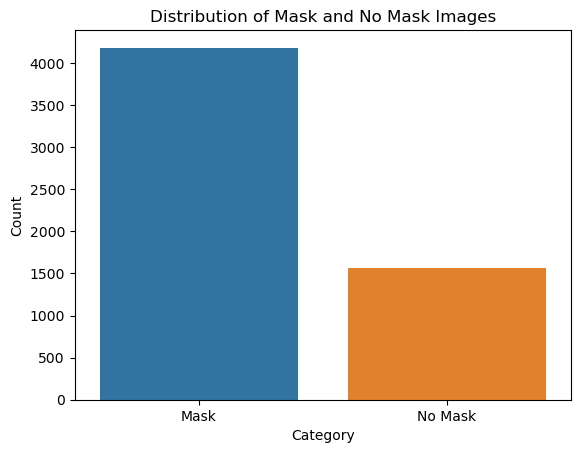

In [17]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels = {'mask': 0, 'without mask': 1}

for i in df_train["name"].unique():
    f = i + ".json"
    for j in getJSON(os.path.join(directory_annot, f)).get("Annotations"):
        if j["classname"] in mask:
            x, y, w, h = j["BoundingBox"]
            img = cv2.imread(os.path.join(directory_images, i), 1)
            img = img[y:h, x:w]
            img = cv2.resize(img, (img_size, img_size))
            data.append([img, labels["mask"]])
        elif j["classname"] in non_mask:
            x, y, w, h = j["BoundingBox"]
            img = cv2.imread(os.path.join(directory_images, i), 1)
            img = img[y:h, x:w]
            img = cv2.resize(img, (img_size, img_size))
            data.append([img, labels["without mask"]])

random.shuffle(data)

# Create a list of labels for the count plot
p = ["Mask" if face[1] == 0 else "No Mask" for face in data]

# Plot the countplot
sns.countplot(x=p)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Mask and No Mask Images')
plt.show()

In [18]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [21]:
xtrain, xval, ytrain, yval = train_test_split(X, Y, train_size=0.8, random_state=0)

# Initializing ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False,  
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,    
    rotation_range=15,    
    width_shift_range=0.1,
    height_shift_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=False
)

# Fitting the ImageDataGenerator to the training data
datagen.fit(xtrain)


In [22]:

# Defining the model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(124, 124, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()

# Training the model using fit
history = model.fit(
    datagen.flow(xtrain, ytrain, batch_size=32),
    steps_per_epoch=len(xtrain) // 32,
    epochs=50,
    validation_data=(xval, yval),
    verbose=1
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 124, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 60, 60, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 460800)            0         
                                                      

In [1]:
test_images = ['1114.png','1504.jpg', '0072.jpg','0001.jpg','0010.jpg','1374.jpg']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(directory_images,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

NameError: name 'plt' is not defined